In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch
np.set_printoptions(suppress=True)

In [2]:
from importlib import reload
import protein_transformer
from protein_transformer.losses import mse_over_angles, mse_over_angles_numpy, inverse_trig_transform
from protein_transformer.losses import angles_to_coords

In [3]:
data = torch.load("../../data/proteinnet/casp12_191101_100.pt")

In [4]:
def add_noise(angs, stdev, truncate=True, keep_zeros=False):
    noise = np.random.normal(0, stdev, angs.shape)
    new_ang = angs + noise
    if truncate:
        new_ang[new_ang > 1] = 1
        new_ang[new_ang < -1] = -1
    if keep_zeros:
        new_ang[angs == 0] = 0
    return new_ang

def rmse(a, b):
    return np.sqrt(((a-b)**2).mean())

In [ ]:
a = data["train"]["ang"][0][:]
a[np.isnan(a)] = 0
np.random.seed(0)
a_noise = add_noise(a, 1, truncate=False)
np.random.seed(0)
a_noise_truncate = add_noise(a, 1, truncate=True)
print(rmse(a, a_noise))
print(rmse(a, a_noise_truncate))

a_torch, a_noise_truncate_torch = torch.tensor(a), torch.tensor(a_noise_truncate)
print(torch.sqrt(mse_over_angles(a_torch.unsqueeze(dim=0), a_noise_truncate_torch.unsqueeze(dim=0))).item())
print(np.sqrt(mse_over_angles_numpy(np.expand_dims(a, 0), np.expand_dims(a_noise_truncate, 0))))

In [5]:
from protein_transformer.protein.structure_utils import get_backbone_from_full_coords

In [6]:
def angles_have_missing_res(angles):
    return np.isnan(angles).all(axis=-1).any()

In [7]:
def get_coordinates_from_numpy_data(seq, ang_sincos):
    # Add batch dimension
    ang_sincos = ang_sincos[np.newaxis, :]
    
    # Compute angles in radians from sin/cos representaion
    ang_rad = inverse_trig_transform(torch.tensor(ang_sincos, dtype=torch.float))[0]
    
    # Remove nans
    ang_rad[torch.isnan(ang_rad)] = 0
    
    if torch.isnan(ang_rad).any():
        print("Nan in ang_rad.")
        
    seq_as_ints = protein_transformer.dataset.VOCAB.aa_seq2indices(seq, add_sos_eos=False)
    seq_as_ints = torch.tensor(seq_as_ints, dtype=torch.long)
    
    coords = angles_to_coords(ang_rad, seq_as_ints, remove_batch_padding=False)
    return coords
    
    

In [ ]:
i = 11
for seq, ang, crd in zip(data["train"]["seq"][i:], data["train"]["ang"][i:], data["train"]["crd"][i:]):
    print(seq)
    print(ang)
    print(crd)
    break

In [8]:
def add_noise_and_get_rmse_drmsd(seq, ang, crd, stdev):
    
    noisy_ang = add_noise(ang, stdev, truncate=True, keep_zeros=False)
#     print(noisy_ang -ang)
    
    coords = get_coordinates_from_numpy_data(seq, ang)
    noisy_coords = get_coordinates_from_numpy_data(seq, noisy_ang)
    
    coords = get_backbone_from_full_coords(coords)
    noisy_coords = get_backbone_from_full_coords(noisy_coords)
    
    rmse_val = np.sqrt(mse_over_angles_numpy(noisy_ang[np.newaxis, :], ang[np.newaxis, :]))
    drmsd_val = protein_transformer.losses.drmsd(coords, noisy_coords)
    rmsd_val = protein_transformer.losses.rmsd(coords.numpy(), noisy_coords.numpy())
    
    crd[np.isnan(crd)] = 0
    true_coords = get_backbone_from_full_coords(crd)
    reconstruction_drmsd = protein_transformer.losses.drmsd(coords, torch.tensor(true_coords))
    reconstruction_rmsd = protein_transformer.losses.rmsd(coords.numpy(), true_coords) 
    
    return rmse_val, rmsd_val, drmsd_val, reconstruction_drmsd, reconstruction_rmsd
    
    

In [ ]:
rm, rd, d, d_recon, rd_recon = add_noise_and_get_rmse_drmsd(seq, ang, crd, 1)
print(f"RMSE:\t\t{rm:.4f},\nRMSD:\t\t{rd:.4f},\nRMSD-recon:\t{rd_recon:.4f},\nDRMSD:\t\t{d:.2f},\nDRMSD-rec:\t{d_recon:.2f}")

In [9]:
import tqdm

In [10]:
def study_noise(stdev):
    pbar = tqdm.tqdm(zip(data["train"]["seq"], data["train"]["ang"], data["train"]["crd"]), total=len(data["train"]["seq"]))
    stats = {"RMSE": [], "RMSD": [], "RMSD-recon": [], "DRMSD" : [], "DRMSD-recon": [], "lengths" : []}
    for seq, ang, crd in pbar:
        rmse_total, rmsd_total, drmsd_total, drmsd_recon_total, rmsd_recon_total = 0, 0, 0, 0, 0
        for i in range(10):
            rm, rd, d, d_recon, rd_recon = add_noise_and_get_rmse_drmsd(seq, ang, crd, stdev)
            rmse_total += rm
            rmsd_total += rd
            drmsd_total += d.item()
            drmsd_recon_total += d_recon.item()
            rmsd_recon_total += rd_recon
            
        stats["RMSE"].append(rmse_total/10)
        stats["RMSD"].append(rmsd_total/10)
        stats["RMSD-recon"].append(rmsd_recon_total/10)
        stats["DRMSD-recon"].append(drmsd_recon_total/10)
        stats["DRMSD"].append(drmsd_total/10)
        stats["lengths"].append(ang.shape[0])
        
    return stats
        

In [ ]:
study_noise(1)

In [11]:
def work(seq_ang_crd_id_stdev):
    seq, ang, crd, _id, stdev = seq_ang_crd_id_stdev
    if angles_have_missing_res(ang):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    rmse_total, rmsd_total, drmsd_total, drmsd_recon_total, rmsd_recon_total = 0, 0, 0, 0, 0
    n = 3
    for i in range(3):
        rm, rd, d, d_recon, rd_recon = add_noise_and_get_rmse_drmsd(seq, ang, crd, stdev)
        rmse_total += rm
        rmsd_total += rd
        drmsd_total += d.item()
        drmsd_recon_total += d_recon.item()
        rmsd_recon_total += rd_recon
    return rmse_total/n, rmsd_total/n, rmsd_recon_total/n, drmsd_total/n, drmsd_recon_total/n, ang.shape[0], stdev, _id
    

In [ ]:
work((seq, ang, crd, 1))

In [12]:
from multiprocessing import Pool
p = Pool(2)


/home/jok120/anaconda3/envs/psp/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/jok120/anaconda3/envs/psp/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/home/jok120/anaconda3/envs/psp/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/jok120/anaconda3/envs/psp/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


In [13]:
import seaborn as sns

In [ ]:
sns.distplot(np.random.exponential(.5, size=1000))

In [ ]:
data["train"]["ang"][4].shape, angles_have_missing_res(data["train"]["ang"][4])

In [ ]:
results1 = list(tqdm.tqdm(p.imap(work, 
                                 zip(data["train"]["seq"][4:5]*1000, 
                                     data["train"]["ang"][4:5]*1000, 
                                     data["train"]["crd"][4:5]*1000, 
                                     np.random.exponential(.5, size=1000))
                               ), total=1000))

In [14]:
lim = None
results = list(tqdm.tqdm(p.imap(work, 
                                 zip(data["train"]["seq"][:lim], 
                                     data["train"]["ang"][:lim], 
                                     data["train"]["crd"][:lim],
                                     data["train"]["ids"][:lim],
                                     np.random.exponential(.5, size=len(data["train"]["seq"][:lim])))
                               ), total=len(data["train"]["seq"][:lim])))

100%|██████████| 85013/85013 [11:05:20<00:00,  2.13it/s]  


In [ ]:
results = p.map(work, 
                  zip(data["train"]["seq"][:200], 
                      data["train"]["ang"][:200], 
                      data["train"]["crd"][:200], 
                      np.random.exponential(.5, size=200)))

In [ ]:
len(results1)

In [15]:
import pandas as pd

In [19]:
sns.set()
sns.set(rc={'figure.facecolor':'white'})

In [16]:
df = pd.DataFrame(results, columns=["rmse", "rmsd", "rmsd-recon", "drmsd", "drmsd-recon","len", "stdev", "id"])

In [17]:
df["ln-drmsd"] = df["drmsd"] / df["len"]
df["ln-rmsd"] = df["rmsd"] / df["len"]

In [18]:
df.to_pickle("complete_train_drmsd_mse_experiment.pkl")

Text(0.5,1,'RMSE vs {RMSD, DRMSD}')

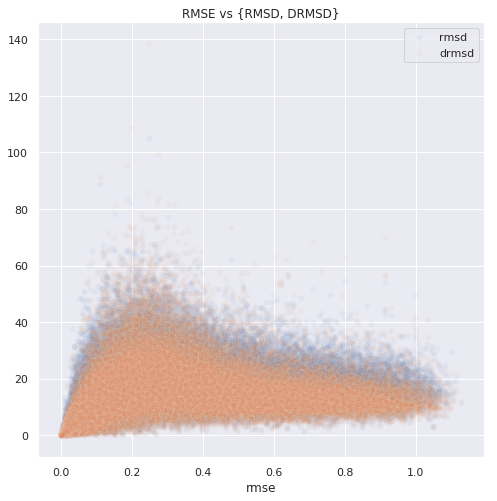

In [22]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
sns.scatterplot(df["rmse"], df["rmsd"], alpha=0.05, ax=ax1, label="rmsd")
sns.scatterplot(df["rmse"], df["drmsd"], alpha=0.05, ax=ax1, label="drmsd")
plt.ylabel("")
plt.legend()
plt.title("RMSE vs {RMSD, DRMSD}")

Text(0.5,1,'RMSE vs {LN-RMSD, LN-DRMSD}')

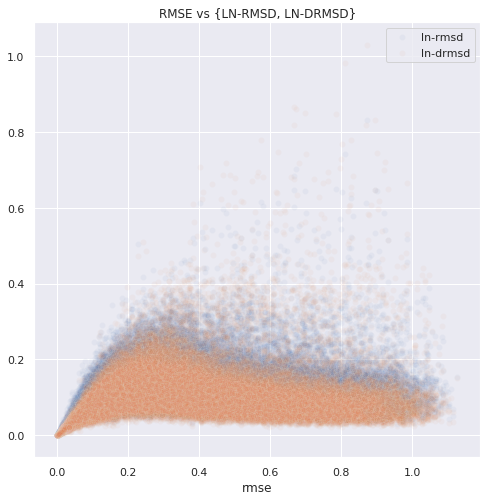

In [23]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
sns.scatterplot(df["rmse"], df["ln-rmsd"], alpha=0.05, ax=ax1, label="ln-rmsd")
sns.scatterplot(df["rmse"], df["ln-drmsd"], alpha=0.05, ax=ax1, label="ln-drmsd")
plt.ylabel("")
plt.legend()
plt.title("RMSE vs {LN-RMSD, LN-DRMSD}")


Text(0.5,1,'RMSE vs LN-RMSD')

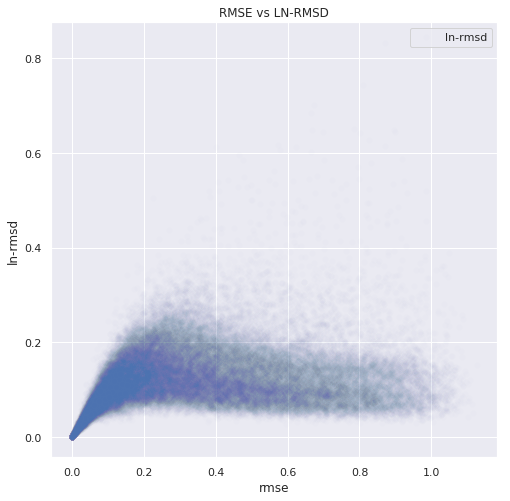

In [27]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
sns.scatterplot(df["rmse"], df["ln-rmsd"], alpha=0.01, ax=ax1, label="ln-rmsd")
plt.title("RMSE vs LN-RMSD")


Text(0.5,1,'RMSE vs RMSD')

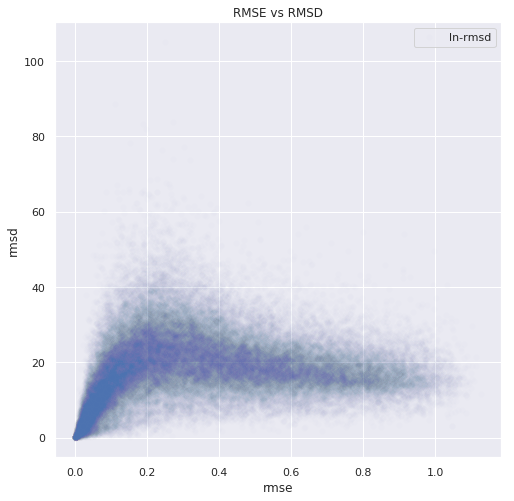

In [28]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
sns.scatterplot(df["rmse"], df["rmsd"], alpha=0.01, ax=ax1, label="ln-rmsd")
plt.title("RMSE vs RMSD")


In [30]:
df_nona = df.dropna()

(0, 6)

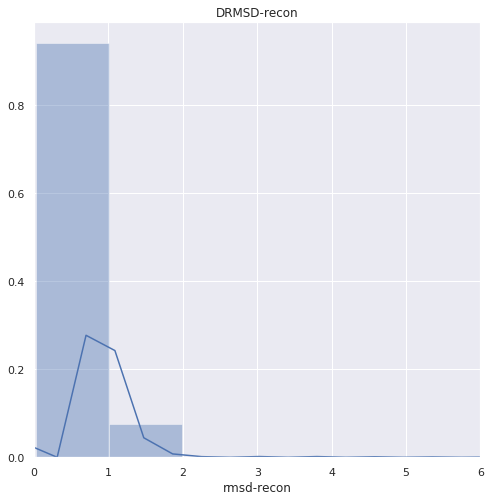

In [32]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
sns.distplot(df_nona["rmsd-recon"])
plt.title("DRMSD-recon")
plt.xlim((0,6))

In [ ]:
df_nona[df_nona["rmsd-recon"]>2]

(0, 13)

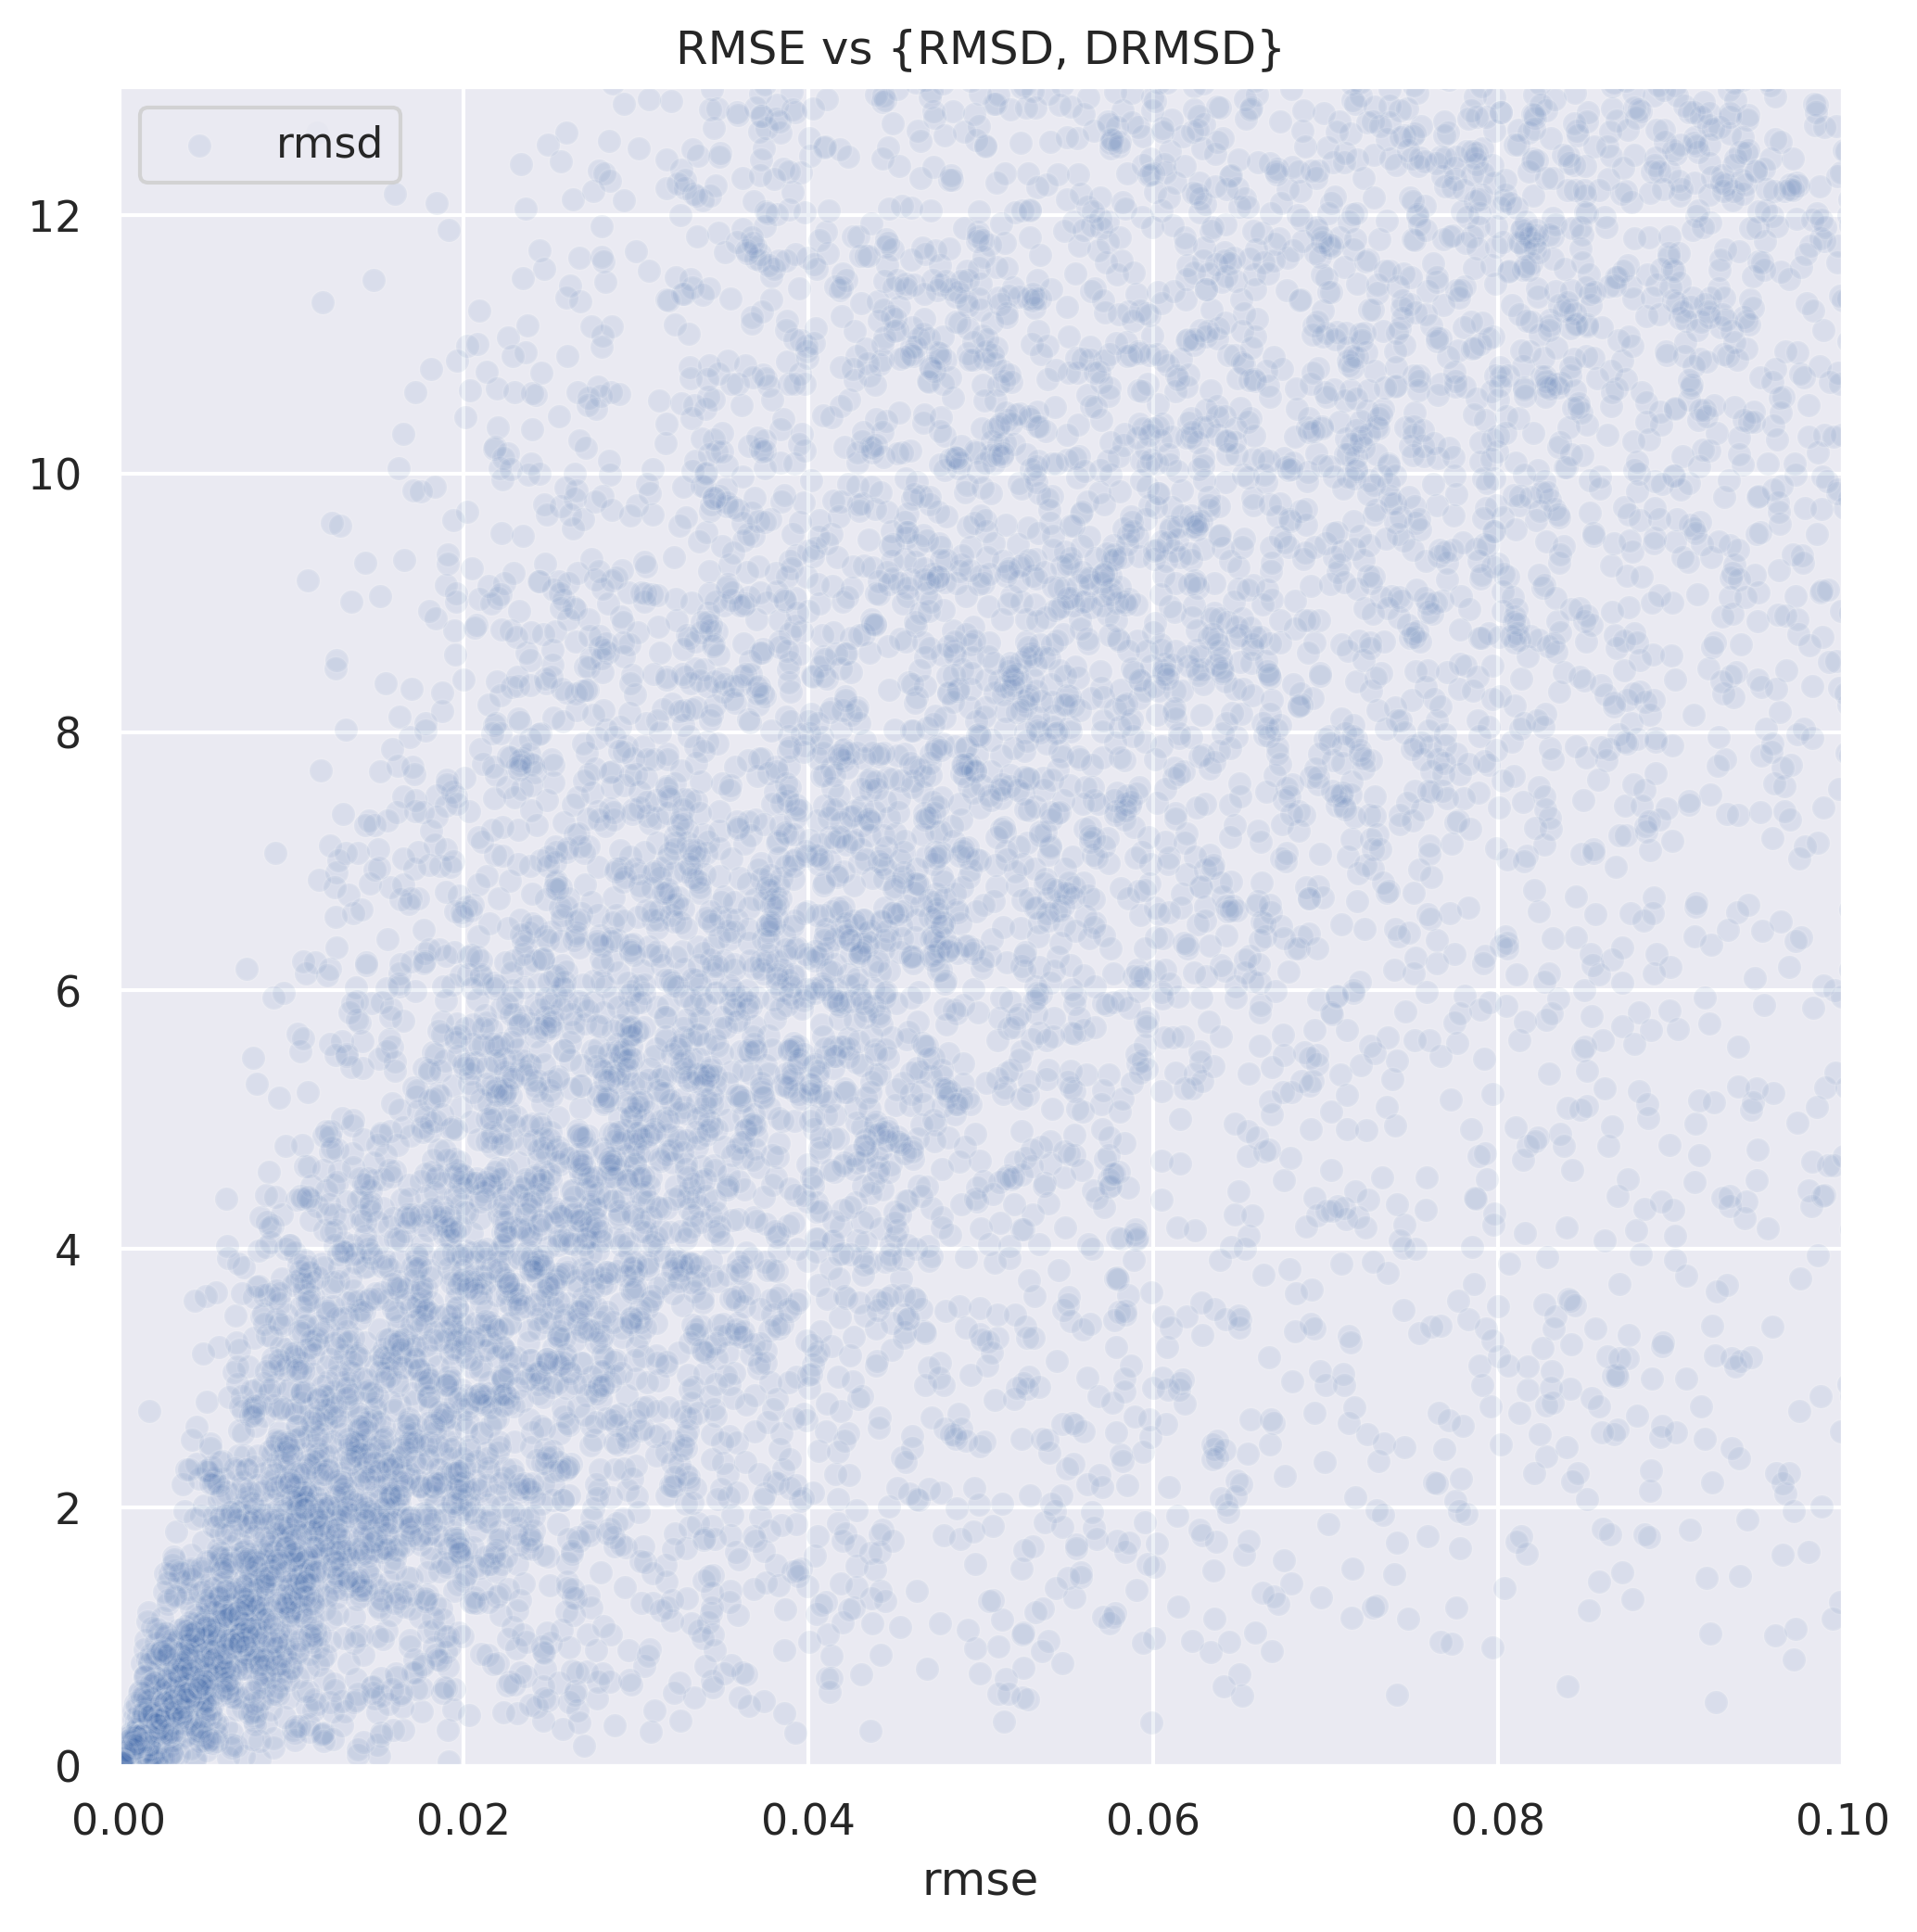

In [36]:
fig = plt.figure(figsize=(8,8), dpi=300)
ax1 = fig.add_subplot(111)
sns.scatterplot(df["rmse"], df["rmsd"], alpha=0.1, ax=ax1, label="rmsd")
# sns.scatterplot(df["rmse"], df["drmsd"], alpha=0.1, ax=ax1, label="drmsd")
plt.ylabel("")
plt.legend()
plt.title("RMSE vs {RMSD, DRMSD}")
plt.xlim((0,0.1))
plt.ylim((0,13))

(0, 0.15)

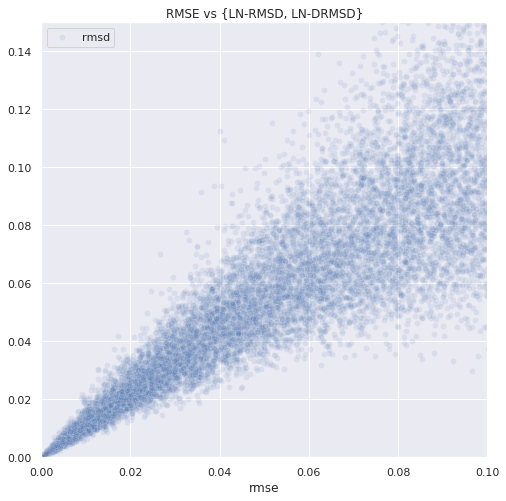

In [37]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
sns.scatterplot(df["rmse"], df["ln-rmsd"], alpha=0.1, ax=ax1, label="rmsd")
# sns.scatterplot(df["rmse"], df["ln-drmsd"], alpha=0.1, ax=ax1, label="drmsd")
plt.ylabel("")
plt.legend()
plt.title("RMSE vs {LN-RMSD, LN-DRMSD}")
plt.xlim((0,0.1))
plt.ylim((0,.15))

(-2, 70)

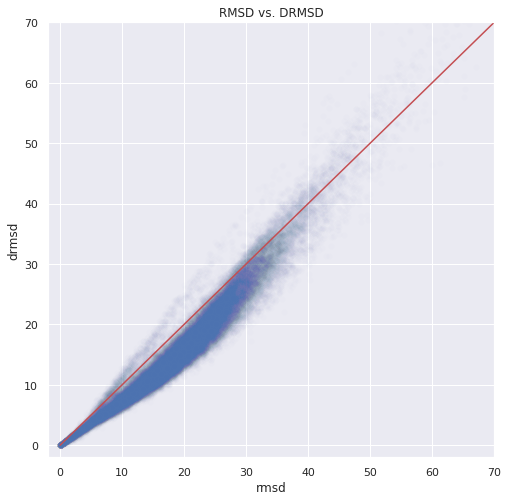

In [40]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
sns.scatterplot(df["rmsd"], df["drmsd"], alpha=0.01)
X_plot = np.linspace(0, 150, 100)
Y_plot = np.linspace(0, 150, 100)
plt.plot(X_plot, Y_plot, color='r')
plt.title("RMSD vs. DRMSD")
plt.xlim((-2, 70))
plt.ylim((-2, 70))

Text(0.5,1,'Distribution of Noise Stdev')

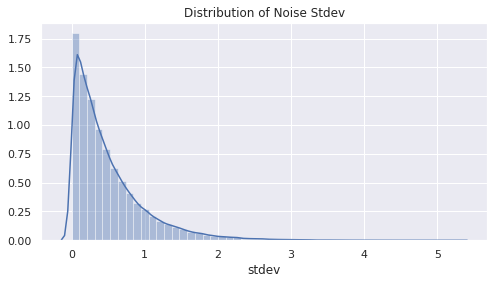

In [41]:
fig = plt.figure(figsize=(8,4))
sns.distplot(df_nona["stdev"])
plt.title("Distribution of Noise Stdev")

In [ ]:
df_nona = df.dropna()

Text(0.5,1,'Distribution of RMSD')

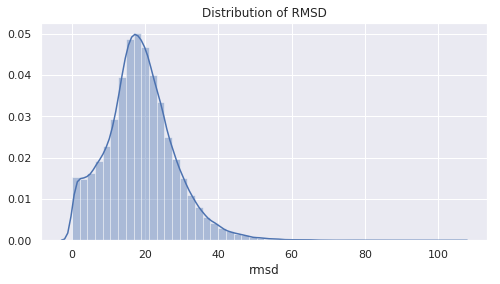

In [42]:
fig = plt.figure(figsize=(8,4))
sns.distplot(df_nona["rmsd"])
plt.title("Distribution of RMSD")

In [ ]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax = sns.regplot(x="rmse", y="ln-rmsd", data=df, 
                 scatter_kws={"alpha": 0.4, "color": "darkgrey"},
                 order=3, truncate=False)
ax = sns.regplot(x="rmse", y="ln-rmsd", data=df, 
                 scatter_kws={"alpha": 0},
                 order=2, truncate=True)
ax = sns.regplot(x="rmse", y="ln-rmsd", data=df, 
                 scatter_kws={"alpha": 0},
                 order=4, truncate=True)
plt.title("Fitting Polynomials to RMSE vs LN-RMSD")

In [ ]:
sns.pairplot(df_nona,  kind="scatter", plot_kws={'alpha':0.1})

In [ ]:
results

In [ ]:
df["ln-drmsd"] = df["drmsd"] / df["len"]

In [ ]:
sns.scatterplot(df["rmse"], df["rmsd"])

In [ ]:
sns.scatterplot(df["rmse"], df["drmsd"])

In [ ]:
sns.scatterplot(df["rmse"], df["ln-drmsd"])

In [ ]:
sns.scatterplot(df["len"], df["drmsd-recon"])

In [ ]:
from protein_transformer.protein.PDB_Creator import PDB_Creator
creator1 = PDB_Creator(c.numpy(), seq=seq, atoms_per_res=3)
creator2 = PDB_Creator(get_backbone_from_full_coords(crd), seq=seq, atoms_per_res=3)

In [ ]:
creator1.save_pdb("reconstructed.pdb")

In [ ]:
creator2.save_pdb("original.pdb")

In [ ]:
pwd1 = protein_transformer.losses.pairwise_internal_dist(c)
pwd2 = protein_transformer.losses.pairwise_internal_dist(torch.tensor(crd))

In [ ]:
pwd2

In [ ]:
pwd1

In [ ]:
c.numpy()[:50]

In [ ]:
crd[:50]

In [ ]:
torch.isnan(c).any(), np.isnan(crd).any() 

In [ ]:
ang

In [ ]:
np.random.seed(0)
ang_noisy = add_noise(ang, 1, truncate=True, keep_zeros=True)

In [ ]:
ang_noisy = add_noise

In [ ]:
c = get_coordinates_from_numpy_data(seq, ang)

In [ ]:
c.shape

In [ ]:
ang.shape

In [ ]:
327*13